# GENERATIVE TEXT TO IMAGE SYNTHESIS PART 4

## IMPORTING THE LIBRARIES

In [1]:
import math #FOR MATHEMATICAL FUNCTIONS
import tensorflow.compat.v1 as tf #USIN VERSION 1 OF TENSORFLOW USING COMPATIBILITY OF TENSORFLOW 2
tf.disable_v2_behavior# WE ARE DISABLING THE USE OF TENSORFLOW VERSION 2 AND USING VERSION 1
tf.disable_eager_execution()#DISABLE THE EAGER EXECUTION AS IT WAS CAUSING SOME TROUBLES DURING TRAINING
from tensorflow.python.framework import ops#FOR SOME TENSORFLOW OPERATIONAL FUNCTIONS
import skimage#SCKIT LEARN IMAGE HANDLING LIBRARY
import skimage.io
import imageio#READING IMAGE FILES
import skimage.transform#TRANSFORM IMAGES PROPERTIES
!pip install tf_slim
import tf_slim as slim# HELPS IN BUILDING COMPLEX MODELS EASILY
import pickle# FOR LOADING THE PICKLES FILES FROM PART 1
import scipy.misc
import random#FOR RANDOM VALUES
import os#FOR OS OPERATIONS
import shutil#FOR HIGH LEVEL FILE OPERATIONS
import numpy as np#NUMERICAL CALCULATIONS LIBBRARY
from os.path import join#TO JOIN FILE PATHS
import sys
import tarfile#FOR EXTRACTING TAR FILES
import theano
import theano.tensor as tensor #FOR HANDLING MATHEMATICAL EXPRESSION OF MULTI DIMENSION ARRAY'S
import _pickle as pkl#STORING THE PREPROCESSED DATA IN PICKLE FILES
import numpy#MATHEMATICAL LIBRARY
import copy#TO CREATE OBJECT COPIES
import nltk# NATURAL LANGUAGE MODULE
from collections import OrderedDict, defaultdict#TO STORE DATA IN COLLECTIONS FORM
from scipy.linalg import norm#FOR SCIENTIFIC CALCULATION
from nltk.tokenize import word_tokenize#FOR WORD TOKENIZATION
import os#FOR OS RELATED FUNCTIONS
import traceback
import pickle
import random
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from PIL import Image as image
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 7.2 MB/s eta 0:00:0000:01


## FUNCTION FOR USING THE SKIP THOUGHT MODEL TO CONVERT CAPTION INTO SKIP THOUGH VECTORS

In [2]:

#-----------------------------------------------------------------------------#
path_to_models = '/kaggle/input/generative-text-to-image-synthesis-part-1/Data/Flowers/skipthoughts/'
path_to_tables = '/kaggle/input/generative-text-to-image-synthesis-part-1/Data/Flowers/skipthoughts/'
#-----------------------------------------------------------------------------#

path_to_umodel = path_to_models + 'uni_skip.npz'
path_to_bmodel = path_to_models + 'bi_skip.npz'


def load_model():
    """
    Load the model with saved tables
    """
    # Load model options
    print('Loading model parameters...')
    with open('%s.pkl'%path_to_umodel, 'rb') as f:
        uoptions = pkl.load(f)
    with open('%s.pkl'%path_to_bmodel, 'rb') as f:
        boptions = pkl.load(f)

    # Load parameters
    uparams = init_params(uoptions)
    uparams = load_params(path_to_umodel, uparams)
    utparams = init_tparams(uparams)
    bparams = init_params_bi(boptions)
    bparams = load_params(path_to_bmodel, bparams)
    btparams = init_tparams(bparams)

    # Extractor functions
    print('Compiling encoders...')
    embedding, x_mask, ctxw2v = build_encoder(utparams, uoptions)
    f_w2v = theano.function([embedding, x_mask], ctxw2v, name='f_w2v')
    embedding, x_mask, ctxw2v = build_encoder_bi(btparams, boptions)
    f_w2v2 = theano.function([embedding, x_mask], ctxw2v, name='f_w2v2')

    # Tables
    print('Loading tables...')
    utable, btable = load_tables()

    # Store everything we need in a dictionary
    print('Packing up...')
    model = {}
    model['uoptions'] = uoptions
    model['boptions'] = boptions
    model['utable'] = utable
    model['btable'] = btable
    model['f_w2v'] = f_w2v
    model['f_w2v2'] = f_w2v2

    return model


def load_tables():
    """
    Load the tables
    """
    words = []
    utable = numpy.load(path_to_tables + 'utable.npy', encoding='bytes',allow_pickle=True)
    btable = numpy.load(path_to_tables + 'btable.npy', encoding='bytes',allow_pickle=True)
    f = open(path_to_tables + 'dictionary.txt', 'rb')
    for line in f:
        words.append(line.decode('utf-8').strip())
    f.close()
    utable = OrderedDict(zip(words, utable))
    btable = OrderedDict(zip(words, btable))
    return utable, btable


def encode(model, X, use_norm=True, verbose=True, batch_size=128, use_eos=False):
    """
    Encode sentences in the list X. Each entry will return a vector
    """
    # first, do preprocessing
    X = preprocess(X)

    # word dictionary and init
    d = defaultdict(lambda : 0)
    for w in model['utable'].keys():
        d[w] = 1
    ufeatures = numpy.zeros((len(X), model['uoptions']['dim']), dtype='float32')
    bfeatures = numpy.zeros((len(X), 2 * model['boptions']['dim']), dtype='float32')

    # length dictionary
    ds = defaultdict(list)
    captions = [s.split() for s in X]
    for i,s in enumerate(captions):
        ds[len(s)].append(i)

    # Get features. This encodes by length, in order to avoid wasting computation
    for k in ds.keys():
        if verbose:
            print(k)
        numbatches = len(ds[k]) / batch_size + 1
        for minibatch in range(int(numbatches)):
            caps = ds[k][int(minibatch)::int(numbatches)]

            if use_eos:
                uembedding = numpy.zeros((k+1, len(caps), model['uoptions']['dim_word']), dtype='float32')
                bembedding = numpy.zeros((k+1, len(caps), model['boptions']['dim_word']), dtype='float32')
            else:
                uembedding = numpy.zeros((k, len(caps), model['uoptions']['dim_word']), dtype='float32')
                bembedding = numpy.zeros((k, len(caps), model['boptions']['dim_word']), dtype='float32')
            for ind, c in enumerate(caps):
                caption = captions[c]
                for j in range(len(caption)):
                    if d[caption[j]] > 0:
                        uembedding[j,ind] = model['utable'][caption[j]]
                        bembedding[j,ind] = model['btable'][caption[j]]
                    else:
                        uembedding[j,ind] = model['utable']['UNK']
                        bembedding[j,ind] = model['btable']['UNK']
                if use_eos:
                    uembedding[-1,ind] = model['utable']['<eos>']
                    bembedding[-1,ind] = model['btable']['<eos>']
            if use_eos:
                uff = model['f_w2v'](uembedding, numpy.ones((len(caption)+1,len(caps)), dtype='float32'))
                bff = model['f_w2v2'](bembedding, numpy.ones((len(caption)+1,len(caps)), dtype='float32'))
            else:
                uff = model['f_w2v'](uembedding, numpy.ones((len(caption),len(caps)), dtype='float32'))
                bff = model['f_w2v2'](bembedding, numpy.ones((len(caption),len(caps)), dtype='float32'))
            if use_norm:
                for j in range(len(uff)):
                    uff[j] /= norm(uff[j])
                    bff[j] /= norm(bff[j])
            for ind, c in enumerate(caps):
                ufeatures[c] = uff[ind]
                bfeatures[c] = bff[ind]

    features = numpy.c_[ufeatures, bfeatures]
    return features


def preprocess(text):
    """
    Preprocess text for encoder
    """
    X = []
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    for t in text:
        sents = sent_detector.tokenize(t)
        result = ''
        for s in sents:
            tokens = word_tokenize(s)
            result += ' ' + ' '.join(tokens)
        X.append(result)
    return X


def nn(model, text, vectors, query, k=5):
    """
    Return the nearest neighbour sentences to query
    text: list of sentences
    vectors: the corresponding representations for text
    query: a string to search
    """
    qf = encode(model, [query])
    qf /= norm(qf)
    scores = numpy.dot(qf, vectors.T).flatten()
    sorted_args = numpy.argsort(scores)[::-1]
    sentences = [text[a] for a in sorted_args[:k]]
    print('QUERY: ' + query)
    print('NEAREST: ')
    for i, s in enumerate(sentences):
        print(s, sorted_args[i])


def word_features(table):
    """
    Extract word features into a normalized matrix
    """
    features = numpy.zeros((len(table), 620), dtype='float32')
    keys = table.keys()
    for i in range(len(table)):
        f = table[keys[i]]
        features[i] = f / norm(f)
    return features


def nn_words(table, wordvecs, query, k=10):
    """
    Get the nearest neighbour words
    """
    keys = table.keys()
    qf = table[query]
    scores = numpy.dot(qf, wordvecs.T).flatten()
    sorted_args = numpy.argsort(scores)[::-1]
    words = [keys[a] for a in sorted_args[:k]]
    print('QUERY: ' + query)
    print('NEAREST: ')
    for i, w in enumerate(words):
        print(w)


def _p(pp, name):
    """
    make prefix-appended name
    """
    return '%s_%s'%(pp, name)


def init_tparams(params):
    """
    initialize Theano shared variables according to the initial parameters
    """
    tparams = OrderedDict()
    for kk, pp in params.items():
        tparams[kk] = theano.shared(params[kk], name=kk)
    return tparams


def load_params(path, params):
    """
    load parameters
    """
    pp = numpy.load(path)
    for kk, vv in params.items():
        if kk not in pp:
            warnings.warn('%s is not in the archive'%kk)
            continue
        params[kk] = pp[kk]
    return params


# layers: 'name': ('parameter initializer', 'feedforward')
layers = {'gru': ('param_init_gru', 'gru_layer')}

def get_layer(name):
    fns = layers[name]
    return (eval(fns[0]), eval(fns[1]))


def init_params(options):
    """
    initialize all parameters needed for the encoder
    """
    params = OrderedDict()

    # embedding
    params['Wemb'] = norm_weight(options['n_words_src'], options['dim_word'])

    # encoder: GRU
    params = get_layer(options['encoder'])[0](options, params, prefix='encoder',
                                              nin=options['dim_word'], dim=options['dim'])
    return params


def init_params_bi(options):
    """
    initialize all paramters needed for bidirectional encoder
    """
    params = OrderedDict()

    # embedding
    params['Wemb'] = norm_weight(options['n_words_src'], options['dim_word'])

    # encoder: GRU
    params = get_layer(options['encoder'])[0](options, params, prefix='encoder',
                                              nin=options['dim_word'], dim=options['dim'])
    params = get_layer(options['encoder'])[0](options, params, prefix='encoder_r',
                                              nin=options['dim_word'], dim=options['dim'])
    return params


def build_encoder(tparams, options):
    """
    build an encoder, given pre-computed word embeddings
    """
    # word embedding (source)
    embedding = tensor.tensor3('embedding', dtype='float32')
    x_mask = tensor.matrix('x_mask', dtype='float32')

    # encoder
    proj = get_layer(options['encoder'])[1](tparams, embedding, options,
                                            prefix='encoder',
                                            mask=x_mask)
    ctx = proj[0][-1]

    return embedding, x_mask, ctx


def build_encoder_bi(tparams, options):
    """
    build bidirectional encoder, given pre-computed word embeddings
    """
    # word embedding (source)
    embedding = tensor.tensor3('embedding', dtype='float32')
    embeddingr = embedding[::-1]
    x_mask = tensor.matrix('x_mask', dtype='float32')
    xr_mask = x_mask[::-1]

    # encoder
    proj = get_layer(options['encoder'])[1](tparams, embedding, options,
                                            prefix='encoder',
                                            mask=x_mask)
    projr = get_layer(options['encoder'])[1](tparams, embeddingr, options,
                                             prefix='encoder_r',
                                             mask=xr_mask)

    ctx = tensor.concatenate([proj[0][-1], projr[0][-1]], axis=1)

    return embedding, x_mask, ctx


# some utilities
def ortho_weight(ndim):
    W = numpy.random.randn(ndim, ndim)
    u, s, v = numpy.linalg.svd(W)
    return u.astype('float32')


def norm_weight(nin,nout=None, scale=0.1, ortho=True):
    if nout == None:
        nout = nin
    if nout == nin and ortho:
        W = ortho_weight(nin)
    else:
        W = numpy.random.uniform(low=-scale, high=scale, size=(nin, nout))
    return W.astype('float32')


def param_init_gru(options, params, prefix='gru', nin=None, dim=None):
    """
    parameter init for GRU
    """
    if nin == None:
        nin = options['dim_proj']
    if dim == None:
        dim = options['dim_proj']
    W = numpy.concatenate([norm_weight(nin,dim),
                           norm_weight(nin,dim)], axis=1)
    params[_p(prefix,'W')] = W
    params[_p(prefix,'b')] = numpy.zeros((2 * dim,)).astype('float32')
    U = numpy.concatenate([ortho_weight(dim),
                           ortho_weight(dim)], axis=1)
    params[_p(prefix,'U')] = U

    Wx = norm_weight(nin, dim)
    params[_p(prefix,'Wx')] = Wx
    Ux = ortho_weight(dim)
    params[_p(prefix,'Ux')] = Ux
    params[_p(prefix,'bx')] = numpy.zeros((dim,)).astype('float32')

    return params


def gru_layer(tparams, state_below, options, prefix='gru', mask=None, **kwargs):
    """
    Forward pass through GRU layer
    """
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    dim = tparams[_p(prefix,'Ux')].shape[1]

    if mask == None:
        mask = tensor.alloc(1., state_below.shape[0], 1)

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n*dim:(n+1)*dim]
        return _x[:, n*dim:(n+1)*dim]

    state_below_ = tensor.dot(state_below, tparams[_p(prefix, 'W')]) + tparams[_p(prefix, 'b')]
    state_belowx = tensor.dot(state_below, tparams[_p(prefix, 'Wx')]) + tparams[_p(prefix, 'bx')]
    U = tparams[_p(prefix, 'U')]
    Ux = tparams[_p(prefix, 'Ux')]

    def _step_slice(m_, x_, xx_, h_, U, Ux):
        preact = tensor.dot(h_, U)
        preact += x_

        r = tensor.nnet.sigmoid(_slice(preact, 0, dim))
        u = tensor.nnet.sigmoid(_slice(preact, 1, dim))

        preactx = tensor.dot(h_, Ux)
        preactx = preactx * r
        preactx = preactx + xx_

        h = tensor.tanh(preactx)

        h = u * h_ + (1. - u) * h
        h = m_[:,None] * h + (1. - m_)[:,None] * h_

        return h

    seqs = [mask, state_below_, state_belowx]
    _step = _step_slice

    rval, updates = theano.scan(_step,
                                sequences=seqs,
                                outputs_info = [tensor.alloc(0., n_samples, dim)],
                                non_sequences = [tparams[_p(prefix, 'U')],
                                                 tparams[_p(prefix, 'Ux')]],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps,
                                profile=False,
                                strict=True)
    rval = [rval]
    return rval


## UTILITY FUNCTIONS

In [3]:


# CLASS FOR BATCH NORMALIZATION 
class batch_norm(object):
    
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum

            self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
            self.name = name

#     FUNCTION FOR TRAINING THE GAN MODEL ON THE SKIP THOUGHT VECTORS
    def __call__(self, x, train=True):
        shape = x.get_shape().as_list()

        if train:
            with tf.variable_scope(self.name) as scope:
                self.beta = tf.get_variable("beta", [shape[-1]],
                                    initializer=tf.constant_initializer(0.))
                self.gamma = tf.get_variable("gamma", [shape[-1]],
                                    initializer=tf.random_normal_initializer(1., 0.02))

                try:
                    batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
                except:
                    batch_mean, batch_var = tf.nn.moments(x, [0, 1], name='moments')

                ema_apply_op = self.ema.apply([batch_mean, batch_var])
                self.ema_mean, self.ema_var = self.ema.average(batch_mean), self.ema.average(batch_var)

                with tf.control_dependencies([ema_apply_op]):
                    mean, var = tf.identity(batch_mean), tf.identity(batch_var)
        else:
            mean, var = self.ema_mean, self.ema_var

        normed = tf.nn.batch_norm_with_global_normalization(
                x, mean, var, self.beta, self.gamma, self.epsilon, scale_after_normalization=True)

        return normed


# FUNCTION TO COMPUTE BINARY CROSS ENTROPY
def binary_cross_entropy(preds, targets, name=None):
    eps = 1e-12
    with ops.op_scope([preds, targets], name, "bce_loss") as name:
        preds = ops.convert_to_tensor(preds, name="preds")
        targets = ops.convert_to_tensor(targets, name="targets")
        return tf.reduce_mean(-(targets * tf.log(preds + eps) +
                              (1. - targets) * tf.log(1. - preds + eps)))
# Concatenate conditioning vector on feature map axis
def conv_cond_concat(x, y):
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    return tf.concat(3, [x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])])

# FUNCTION FOR CONVOLUTION2D LAYER
def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
           name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim], initializer = tf.keras.initializers.glorot_normal())
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

        return conv

# FUNCTION FOR DECONVOLUTION2D LAYER
def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
             name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_h, output_shape[-1], input_.get_shape()[-1]], initializer = tf.keras.initializers.glorot_normal())
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])

        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv

# FUNCTION FOR LEAKY RELU FUNCTION
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

# FUNCTION FOR LINEAR LAYER
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0,
           with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.keras.initializers.glorot_normal())
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias



# FUNCTION FORCALLING THE GENERATOR
def get_gt(batch_size, classes, real=1, name="gt"):

    with tf.variable_scope(name, reuse=None):
        r_f = tf.get_variable("rf", [batch_size, 1],
                               initializer = tf.constant_initializer(
                                   real))
        gt = tf.concat(1, [r_f, classes], name = 'gt_concat_classes')
        return gt

## FUNCTION TO CREATE GAN MODEL

In [4]:
# CLASS FOR CREATING THE GAN
class GAN :

    
#     FUNCTION FOR GAN MODEL INITILIZATION
    def __init__(self, options) :
        self.options = options

#     FUNCTION TO BUILD THE MODEL
    def build_model(self) :

        
        print('Initializing placeholder')
        img_size = self.options['image_size']
        t_real_image = tf.placeholder('float32', [self.options['batch_size'],
                                      img_size, img_size, 3],
                                      name = 'real_image')
        t_wrong_image = tf.placeholder('float32', [self.options['batch_size'],
                                       img_size, img_size, 3],
                                       name = 'wrong_image')

        t_real_caption = tf.placeholder('float32', [self.options['batch_size'],
                                        self.options['caption_vector_length']],
                                        name='real_captions')

        t_z = tf.placeholder('float32', [self.options['batch_size'],
                              self.options['z_dim']], name='input_noise')

        t_real_classes = tf.placeholder('float32', [self.options['batch_size'],
                                        self.options['n_classes']],
                                        name='real_classes')

        t_wrong_classes = tf.placeholder('float32', [self.options['batch_size'],
                                         self.options['n_classes']],
                                         name='wrong_classes')

        t_training = tf.placeholder(tf.bool, name='training')

#         BUILDING THE GENERATOR
        print('Building the Generator')
        fake_image = self.generator(t_z, t_real_caption,
                                                 t_training)

#         BUILDING THE DISCRIMINATOR
        print('Building the Discriminator')
        disc_real_image, disc_real_image_logits, disc_real_image_aux, \
            disc_real_image_aux_logits = self.discriminator(
                t_real_image, t_real_caption, self.options['n_classes'],
                t_training)

        disc_wrong_image, disc_wrong_image_logits, disc_wrong_image_aux, \
            disc_wrong_image_aux_logits  = self.discriminator(
                t_wrong_image, t_real_caption, self.options['n_classes'],
                t_training, reuse = True)

        disc_fake_image, disc_fake_image_logits, disc_fake_image_aux, \
            disc_fake_image_aux_logits  = self.discriminator(
                fake_image, t_real_caption, self.options['n_classes'],
                t_training, reuse = True)

        d_right_predictions = tf.equal(tf.argmax(disc_real_image_aux, 1),
                                       tf.argmax(t_real_classes, 1))
        d_right_accuracy = tf.reduce_mean(tf.cast(d_right_predictions,
                                                  tf.float32))

        d_wrong_predictions = tf.equal(tf.argmax(disc_wrong_image_aux, 1),
                                       tf.argmax(t_wrong_classes, 1))
        d_wrong_accuracy = tf.reduce_mean(tf.cast(d_wrong_predictions,
                                                  tf.float32))

        d_fake_predictions = tf.equal(tf.argmax(disc_fake_image_aux_logits, 1),
                                      tf.argmax(t_real_classes, 1))
        d_fake_accuracy = tf.reduce_mean(tf.cast(d_fake_predictions,
                                                 tf.float32))

        tf.get_variable_scope()._reuse = False

#         BUILDING THE LOSS FUNCTION FOR THE GENERATOR AND DISCRIMINATOR
        print('Building the Loss Function')
        g_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                  logits=disc_fake_image_logits,
                                  labels=tf.ones_like(disc_fake_image)))

        g_loss_2 = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                                            logits=disc_fake_image_aux_logits,
                                            labels=t_real_classes))

        d_loss1 = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                                        logits=disc_real_image_logits,
                                        labels=tf.ones_like(disc_real_image)))
        d_loss1_1 = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                                            logits=disc_real_image_aux_logits,
                                            labels=t_real_classes))
        d_loss2 = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=disc_wrong_image_logits,
                                    labels=tf.zeros_like(disc_wrong_image)))
        d_loss2_1 = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                                            logits=disc_wrong_image_aux_logits,
                                            labels=t_wrong_classes))
        d_loss3 = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                                        logits=disc_fake_image_logits,
                                        labels=tf.zeros_like(disc_fake_image)))

        d_loss = d_loss1 + d_loss1_1 + d_loss2 + d_loss2_1 + d_loss3 + g_loss_2

        g_loss = g_loss_1 + g_loss_2

        t_vars = tf.trainable_variables()
        
#         PRINT ALL VALUES: GENERATOR/DISCRIMINATOR LOSS, GENERATOR/DISCRIMINATOR LOSS ON REAL/FAKE IMAGE .ETC
        print('List of all variables')
        for v in t_vars:
            print(v.name)
            print(v)
            self.add_histogram_summary(v.name, v)

        self.add_tb_scalar_summaries(d_loss, g_loss, d_loss1, d_loss2, d_loss3,
              d_loss1_1, d_loss2_1, g_loss_1, g_loss_2, d_right_accuracy,
              d_wrong_accuracy, d_fake_accuracy)

        self.add_image_summary('Generated Images', fake_image,
                               self.options['batch_size'])

        d_vars = [var for var in t_vars if 'd_' in var.name]
        g_vars = [var for var in t_vars if 'g_' in var.name]

        input_tensors = {
            't_real_image' : t_real_image,
            't_wrong_image' : t_wrong_image,
            't_real_caption' : t_real_caption,
            't_z' : t_z,
            't_real_classes' : t_real_classes,
            't_wrong_classes' : t_wrong_classes,
            't_training' : t_training,

        }

        variables = {
            'd_vars' : d_vars,
            'g_vars' : g_vars
        }

        loss = {
            'g_loss' : g_loss,
            'd_loss' : d_loss
        }

        outputs = {
            'generator' : fake_image
        }

        checks = {
            'd_loss1': d_loss1,
            'd_loss2': d_loss2,
            'd_loss3': d_loss3,
            'g_loss_1': g_loss_1,
            'g_loss_2': g_loss_2,
            'd_loss1_1': d_loss1_1,
            'd_loss2_1': d_loss2_1,
            'disc_real_image_logits': disc_real_image_logits,
            'disc_wrong_image_logits': disc_wrong_image,
            'disc_fake_image_logits': disc_fake_image_logits
        }

        return input_tensors, variables, loss, outputs, checks

    
    #ADDING THE METRICS DURING TRAINING FOR EACH EPOCH
    def add_tb_scalar_summaries(self, d_loss, g_loss, d_loss1, d_loss2,
                                  d_loss3, d_loss1_1, d_loss2_1, g_loss_1,
                                  g_loss_2, d_right_accuracy,
                                  d_wrong_accuracy, d_fake_accuracy):

        self.add_scalar_summary("D_Loss", d_loss)
        self.add_scalar_summary("G_Loss", g_loss)
        self.add_scalar_summary("D loss-1 [Real/Fake loss for real images]",
                                d_loss1)
        self.add_scalar_summary("D loss-2 [Real/Fake loss for wrong images]",
                                d_loss2)
        self.add_scalar_summary("D loss-3 [Real/Fake loss for fake images]",
                                d_loss3)
        self.add_scalar_summary(
            "D loss-4 [Aux Classifier loss for real images]", d_loss1_1)
        self.add_scalar_summary(
            "D loss-5 [Aux Classifier loss for wrong images]", d_loss2_1)
        self.add_scalar_summary("G loss-1 [Real/Fake loss for fake images]",
                                g_loss_1)
        self.add_scalar_summary(
            "G loss-2 [Aux Classifier loss for fake images]", g_loss_2)
        self.add_scalar_summary("Discriminator Real Image Accuracy",
                                d_right_accuracy)
        self.add_scalar_summary("Discriminator Wrong Image Accuracy",
                                d_wrong_accuracy)
        self.add_scalar_summary("Discriminator Fake Image Accuracy",
                                d_fake_accuracy)

#     FUNCTION TO PRINT IN SCALAR FORMAT
    def add_scalar_summary(self, name, var):
        with tf.name_scope('summaries'):
            tf.summary.scalar(name, var)

#     FUNCTION TO PRINT IN HISTGRAM FORMAT
    def add_histogram_summary(self, name, var):
        with tf.name_scope('summaries'):
            tf.summary.histogram(name, var)

#     FUNCTION TO PRINT IN IMAGE FORMAT
    def add_image_summary(self, name, var, max_outputs=1):
        with tf.name_scope('summaries'):
            tf.summary.image(name, var, max_outputs=max_outputs)

    # GENERATOR IMPLEMENTATION FUNCTION
    def generator(self, t_z, t_text_embedding, t_training):

        s = self.options['image_size']
        s2, s4, s8, s16 = int(s / 2), int(s / 4), int(s / 8), int(s / 16)

        reduced_text_embedding = lrelu(
            linear(t_text_embedding, self.options['t_dim'], 'g_embedding'))
        z_concat = tf.concat([t_z, reduced_text_embedding], -1)
        z_ = linear(z_concat, self.options['gf_dim'] * 8 * s16 * s16,
                        'g_h0_lin')
        h0 = tf.reshape(z_, [-1, s16, s16, self.options['gf_dim'] * 8])
        h0 = tf.nn.relu(slim.batch_norm(h0, is_training = t_training,
                                        scope="g_bn0"))

        h1 = deconv2d(h0, [self.options['batch_size'], s8, s8,
                               self.options['gf_dim'] * 4], name = 'g_h1')
        h1 = tf.nn.relu(slim.batch_norm(h1, is_training = t_training,
                                        scope="g_bn1"))

        h2 = deconv2d(h1, [self.options['batch_size'], s4, s4,
                               self.options['gf_dim'] * 2], name = 'g_h2')
        h2 = tf.nn.relu(slim.batch_norm(h2, is_training = t_training,
                                        scope="g_bn2"))

        h3 = deconv2d(h2, [self.options['batch_size'], s2, s2,
                               self.options['gf_dim'] * 1], name = 'g_h3')
        h3 = tf.nn.relu(slim.batch_norm(h3, is_training = t_training,
                                        scope="g_bn3"))

        h4 = deconv2d(h3, [self.options['batch_size'], s, s, 3],
                          name = 'g_h4')
        return (tf.tanh(h4) / 2. + 0.5)


    # DISCRIMINATOR IMPLEMENTATION FUNCTION
    
    def discriminator(self, image, t_text_embedding, n_classes, t_training,
                      reuse = False) :
        if reuse :
            tf.get_variable_scope().reuse_variables()

        h0 = lrelu(
            conv2d(image, self.options['df_dim'], name = 'd_h0_conv'))  # 64

        h1 = lrelu(slim.batch_norm(conv2d(h0,
                                             self.options['df_dim'] * 2,
                                             name = 'd_h1_conv'),
                                       reuse=reuse,
                                       is_training = t_training,
                                       scope = 'd_bn1'))  # 32

        h2 = lrelu(slim.batch_norm(conv2d(h1,
                                             self.options['df_dim'] * 4,
                                             name = 'd_h2_conv'),
                                       reuse=reuse,
                                       is_training = t_training,
                                       scope = 'd_bn2'))  # 16
        h3 = lrelu(slim.batch_norm(conv2d(h2,
                                             self.options['df_dim'] * 8,
                                             name = 'd_h3_conv'),
                                       reuse=reuse,
                                       is_training = t_training,
                                       scope = 'd_bn3'))  # 8
        h3_shape = h3.get_shape().as_list()
        # ADD TEXT EMBEDDING TO THE NETWORK
        reduced_text_embeddings = lrelu(linear(t_text_embedding,
                                                       self.options['t_dim'],
                                                       'd_embedding'))
        reduced_text_embeddings = tf.expand_dims(reduced_text_embeddings, 1)
        reduced_text_embeddings = tf.expand_dims(reduced_text_embeddings, 2)
        tiled_embeddings = tf.tile(reduced_text_embeddings,
                                   [1, h3_shape[1], h3_shape[1], 1],
                                   name = 'tiled_embeddings')

        h3_concat = tf.concat([h3, tiled_embeddings], 3, name = 'h3_concat')
        h3_new = lrelu(slim.batch_norm(conv2d(h3_concat,
                                                self.options['df_dim'] * 8,
                                                      1, 1, 1, 1,
                                                name = 'd_h3_conv_new'),
                                        reuse=reuse,
                                        is_training = t_training,
                                        scope = 'd_bn4'))  # 4

        h3_flat = tf.reshape(h3_new, [self.options['batch_size'], -1])

        h4 = linear(h3_flat, 1, 'd_h4_lin_rw')
        h4_aux = linear(h3_flat, n_classes, 'd_h4_lin_ac')

        return tf.nn.sigmoid(h4), h4, tf.nn.sigmoid(h4_aux), h4_aux

## WRITE YOUR FLOWER DESCRIPTION TO GENERATE THE CORRESPONDING FLOWER IMAGES

In [5]:

with open("flowers_description.txt", "w") as f:
    accept_more_description = True
    while accept_more_description:
        input_value = input("Please Write Your Flower Image Description To Generate it's Image's, or 'END' (Non-Case Sensitive) If You Are Done.")
        if input_value.upper() == "END":
            break
        f.write(input_value+'\n')

with open('flowers_description.txt', 'rb+') as fh:
    fh.seek(-1, 2)
    fh.truncate()

Please Write Your Flower Image Description To Generate it's Image's, or 'END' (Non-Case Sensitive) If You Are Done. red and green flower 
Please Write Your Flower Image Description To Generate it's Image's, or 'END' (Non-Case Sensitive) If You Are Done. blue flower with yellow anther
Please Write Your Flower Image Description To Generate it's Image's, or 'END' (Non-Case Sensitive) If You Are Done. white flower with green flower
Please Write Your Flower Image Description To Generate it's Image's, or 'END' (Non-Case Sensitive) If You Are Done. red and purple flower
Please Write Your Flower Image Description To Generate it's Image's, or 'END' (Non-Case Sensitive) If You Are Done. black and white flower
Please Write Your Flower Image Description To Generate it's Image's, or 'END' (Non-Case Sensitive) If You Are Done. end


## CONVERTING THE TEXT DESCRIPTION TO SKIP THOUGHT VECTORS

In [6]:

def main():
    
    model = load_model()
    encoded_captions = {}
    file_path = os.path.join('flowers_description.txt')
    dump_path = os.path.join('', 'enc_text.pkl')
    dump_path ='enc_text.pkl'
    with open(file_path) as f:
        str_captions = f.read()
        captions = str_captions.split('\n')
        print(captions)
        encoded_captions['features'] = encode(model, captions)

    pickle.dump(encoded_captions,
                open(dump_path, "wb"))
    print('Finished extracting Skip-Thought vectors of the given text descriptions')

main()

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...
['red and green flower ', 'blue flower with yellow anther', 'white flower with green flower', 'red and purple flower', 'black and white flower']
4
5
Finished extracting Skip-Thought vectors of the given text descriptions


## GENERATING IMAGES FROM THE DESCRIPTIONS

In [7]:

datasets_root_dir = join('Data/Flowers', '')

checkpoints_dir='/kaggle/input/generative-text-to-image-synthesis-part-2-epoch100/Data/Flowers/training/GENERATIVE TEXT TO IMAGE SYNTHESIS GAN MODEL/checkpoints'

pickles_dir='/kaggle/input/generative-text-to-image-synthesis-part-1/Data/Flowers'



def main():

    
    loaded_data = load_training_data(datasets_root_dir, 'flowers',4800,102)
    model_options = {
        'z_dim': 100,
        't_dim': 256,
        'batch_size': 64,
        'image_size': 128,
        'gf_dim': 64,
        'df_dim': 64,
        'caption_vector_length': 4800,
        'n_classes': loaded_data['n_classes']
    }

    gan = GAN(model_options)
    input_tensors, variables, loss, outputs, checks = gan.build_model()

    sess = tf.InteractiveSession()
    tf.initialize_all_variables().run()

    saver = tf.train.Saver(max_to_keep=10000)
    print('Trying to resume model from ' +
          str(tf.train.latest_checkpoint(checkpoints_dir)))
    if tf.train.latest_checkpoint(checkpoints_dir) is not None:
        saver.restore(sess, tf.train.latest_checkpoint(checkpoints_dir))
        print('Successfully loaded model from ')
    else:
        print('Could not load checkpoints. Please provide a valid path to'
              ' your checkpoints directory')
        exit()

    print('Starting to generate images from text descriptions.')
    for sel_i, text_cap in enumerate(loaded_data['text_caps']['features']):

        print('Text idx: {}\nRaw Text: {}\n'.format(sel_i, text_cap))
        captions_1, image_files_1, image_caps_1, image_ids_1,\
        image_caps_ids_1 = get_caption_batch(loaded_data, datasets_root_dir,
                         dataset='flowers', batch_size=64)

        captions_1[64-1, :] = text_cap

        for z_i in range(30):
            z_noise = np.random.uniform(-1, 1, [64, 100])
            val_feed = {
                input_tensors['t_real_caption'].name: captions_1,
                input_tensors['t_z'].name: z_noise,
                input_tensors['t_training'].name: True
            }

            val_gen = sess.run(
                [outputs['generator']],
                feed_dict=val_feed)
            dump_dir = os.path.join('Data/Flowers',
                                    'images_generated_from_text')
            save_distributed_image_batch(dump_dir, val_gen, sel_i, z_i,
                                         64)
    print('Finished generating images from text description')


def load_training_data(data_dir, data_set, caption_vector_length, n_classes):
    if data_set == 'flowers':
        flower_str_captions = pickle.load(
            open(join(pickles_dir+'/pickles', 'flowers_caps.pkl'), "rb"))

        img_classes = pickle.load(
            open(join(pickles_dir+'/pickles', 'flower_tc.pkl'), "rb"))

        flower_enc_captions = pickle.load(
            open(join(pickles_dir+'/pickles', 'flower_tv.pkl'), "rb"))
        # h1 = h5py.File(join(data_dir, 'flower_tc.hdf5'))
        tr_image_ids = pickle.load(
            open(join(pickles_dir+'/pickles', 'train_ids.pkl'), "rb"))
        val_image_ids = pickle.load(
            open(join(pickles_dir, 'val_ids.pkl'), "rb"))
        caps_new = pickle.load(
            open(join('', 'enc_text.pkl'), "rb"))

        # n_classes = n_classes
        max_caps_len = caption_vector_length

        tr_n_imgs = len(tr_image_ids)
        val_n_imgs = len(val_image_ids)

        return {
            'image_list': tr_image_ids,
            'captions': flower_enc_captions,
            'data_length': tr_n_imgs,
            'classes': img_classes,
            'n_classes': n_classes,
            'max_caps_len': max_caps_len,
            'val_img_list': val_image_ids,
            'val_captions': flower_enc_captions,
            'val_data_len': val_n_imgs,
            'str_captions': flower_str_captions,
            'text_caps': caps_new
        }

    else:
        raise Exception('This dataset has not been handeled yet. '
                         'Contributions are welcome.')


def save_distributed_image_batch(data_dir, generated_images, sel_i, z_i,
                                 batch_size=64):
    generated_images = np.squeeze(generated_images)
    folder_name = str(sel_i)
    image_dir = join(data_dir, folder_name)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    fake_image_255 = generated_images[batch_size-1]
    imageio.imwrite(join(image_dir, '{}.jpg'.format(z_i)),
                          fake_image_255)


def get_caption_batch(loaded_data, data_dir, dataset='flowers', batch_size=64):

    captions = np.zeros((batch_size, loaded_data['max_caps_len']))
    batch_idx = np.random.randint(0, loaded_data['data_length'],
                                  size=batch_size)
    image_ids = np.take(loaded_data['image_list'], batch_idx)
    image_files = []
    image_caps = []
    image_caps_ids = []
    for idx, image_id in enumerate(image_ids):
        image_file = join(data_dir, dataset, 'jpg' + image_id)
        random_caption = random.randint(0, 4)
        image_caps_ids.append(random_caption)
        captions[idx, :] = \
            loaded_data['captions'][image_id][random_caption][
            0:loaded_data['max_caps_len']]

        image_caps.append(loaded_data['captions']
                          [image_id][random_caption])
        image_files.append(image_file)

    return captions, image_files, image_caps, image_ids, image_caps_ids


main()

Initializing placeholder
Building the Generator
Building the Discriminator
Building the Loss Function
List of all variables
g_embedding/Matrix:0
<tf.Variable 'g_embedding/Matrix:0' shape=(4800, 256) dtype=float32>
g_embedding/bias:0
<tf.Variable 'g_embedding/bias:0' shape=(256,) dtype=float32>
g_h0_lin/Matrix:0
<tf.Variable 'g_h0_lin/Matrix:0' shape=(356, 32768) dtype=float32>
g_h0_lin/bias:0
<tf.Variable 'g_h0_lin/bias:0' shape=(32768,) dtype=float32>
g_bn0/beta:0
<tf.Variable 'g_bn0/beta:0' shape=(512,) dtype=float32>
g_h1/w:0
<tf.Variable 'g_h1/w:0' shape=(5, 5, 256, 512) dtype=float32>
g_h1/biases:0
<tf.Variable 'g_h1/biases:0' shape=(256,) dtype=float32>
g_bn1/beta:0
<tf.Variable 'g_bn1/beta:0' shape=(256,) dtype=float32>
g_h2/w:0
<tf.Variable 'g_h2/w:0' shape=(5, 5, 128, 256) dtype=float32>
g_h2/biases:0
<tf.Variable 'g_h2/biases:0' shape=(128,) dtype=float32>
g_bn2/beta:0
<tf.Variable 'g_bn2/beta:0' shape=(128,) dtype=float32>
g_h3/w:0
<tf.Variable 'g_h3/w:0' shape=(5, 5, 64, 12

## VIEWING THE GENERATED IMAGES

# __<p style="text-align: center;">Images Generated From Text Description</p>__

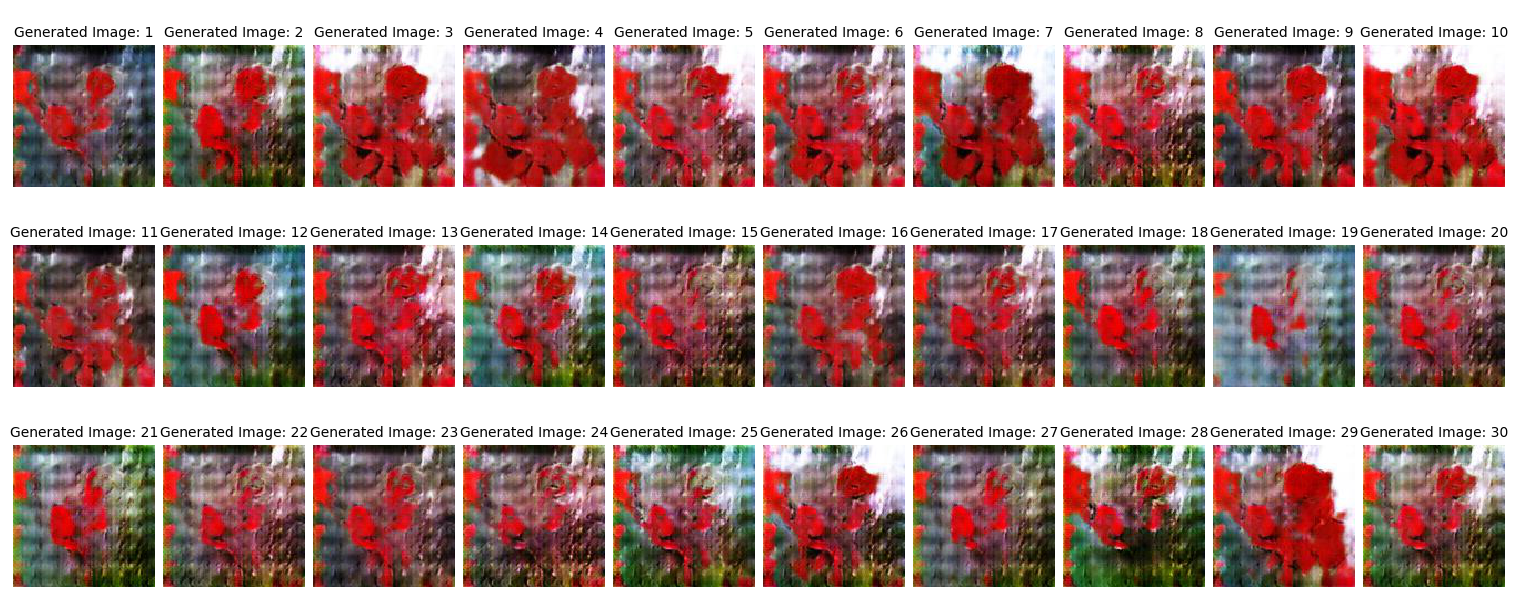

#### __Image Description 1:__ <u>_Red And Green Flower _ 


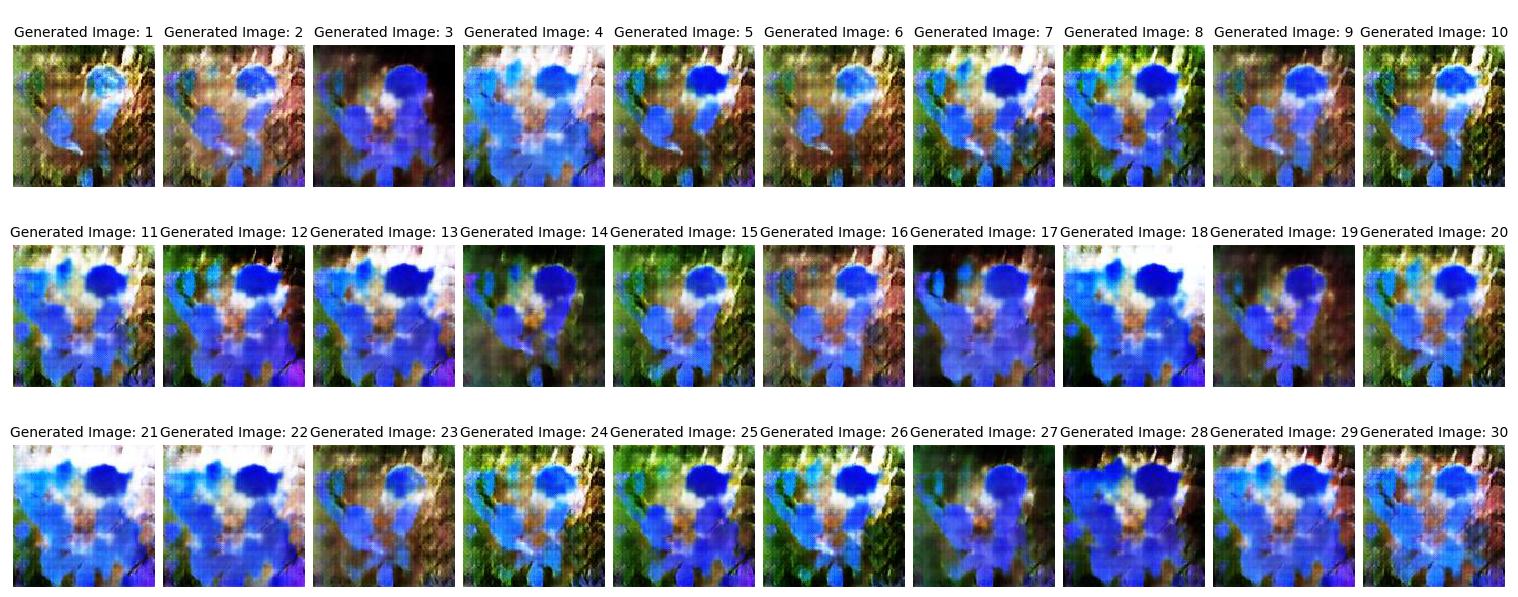

#### __Image Description 2:__ <u>_Blue Flower With Yellow Anther_ 


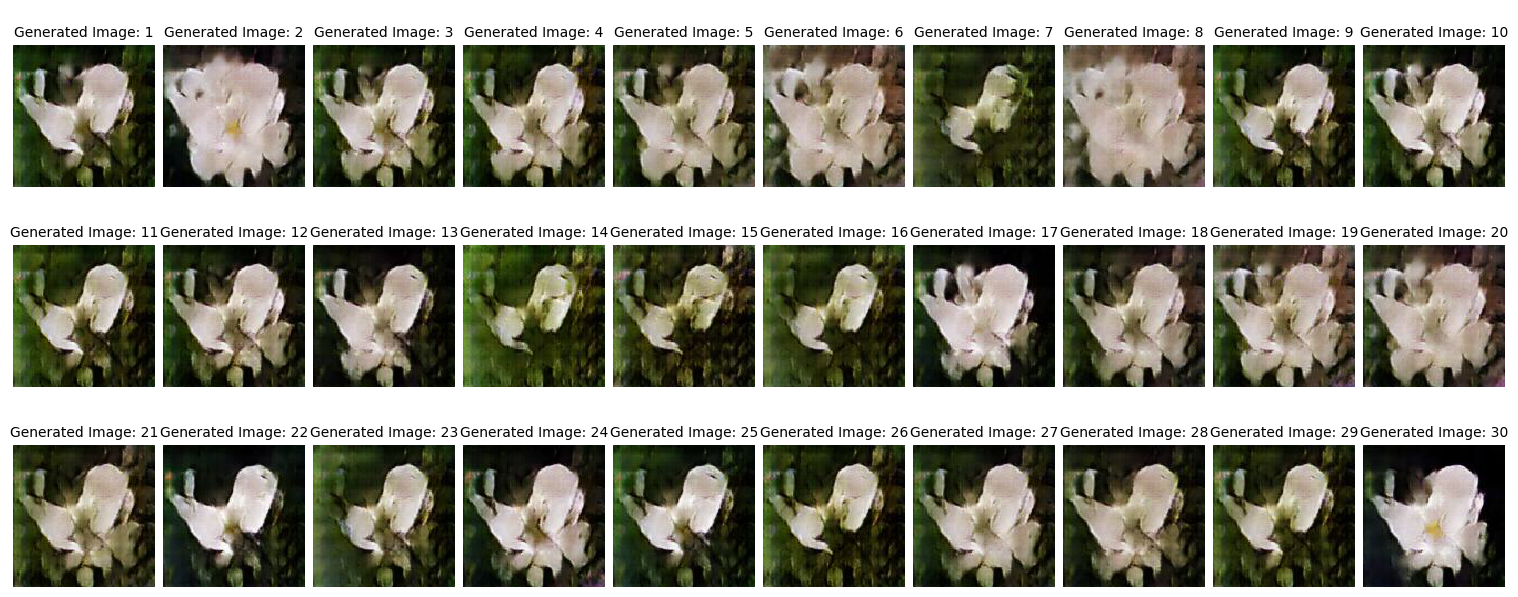

#### __Image Description 3:__ <u>_White Flower With Green Flower_ 


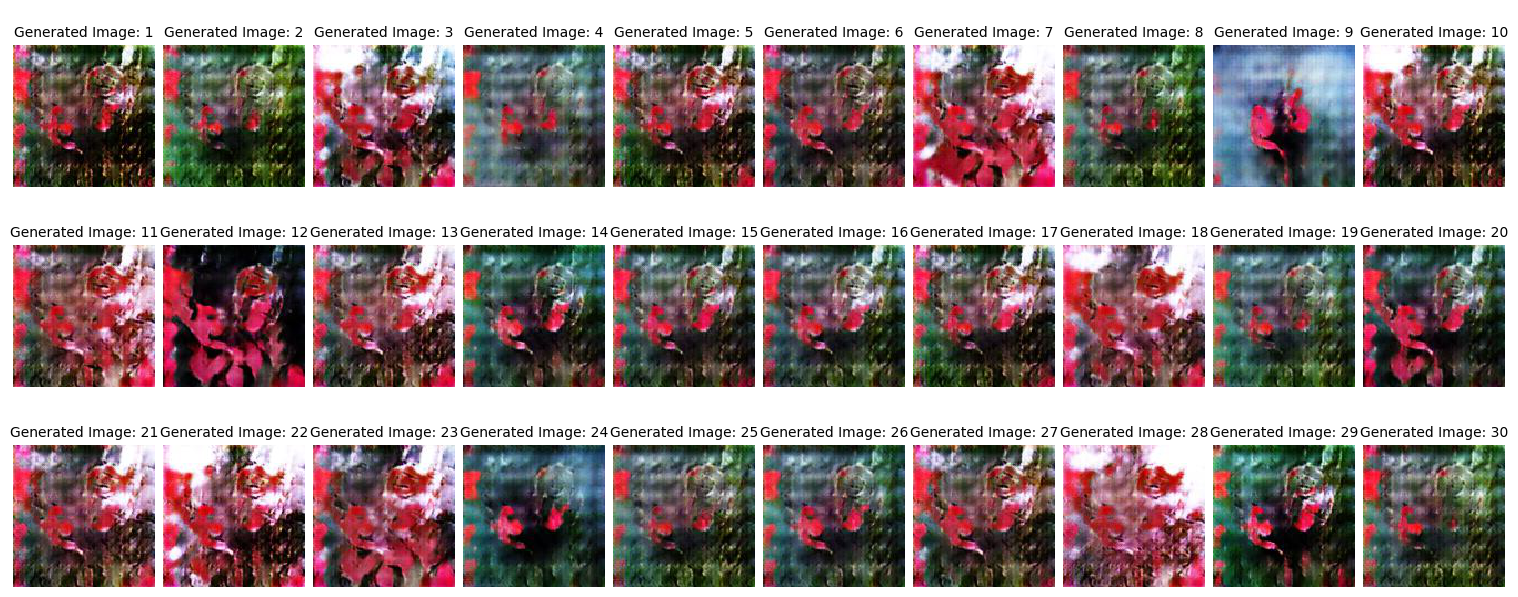

#### __Image Description 4:__ <u>_Red And Purple Flower_ 


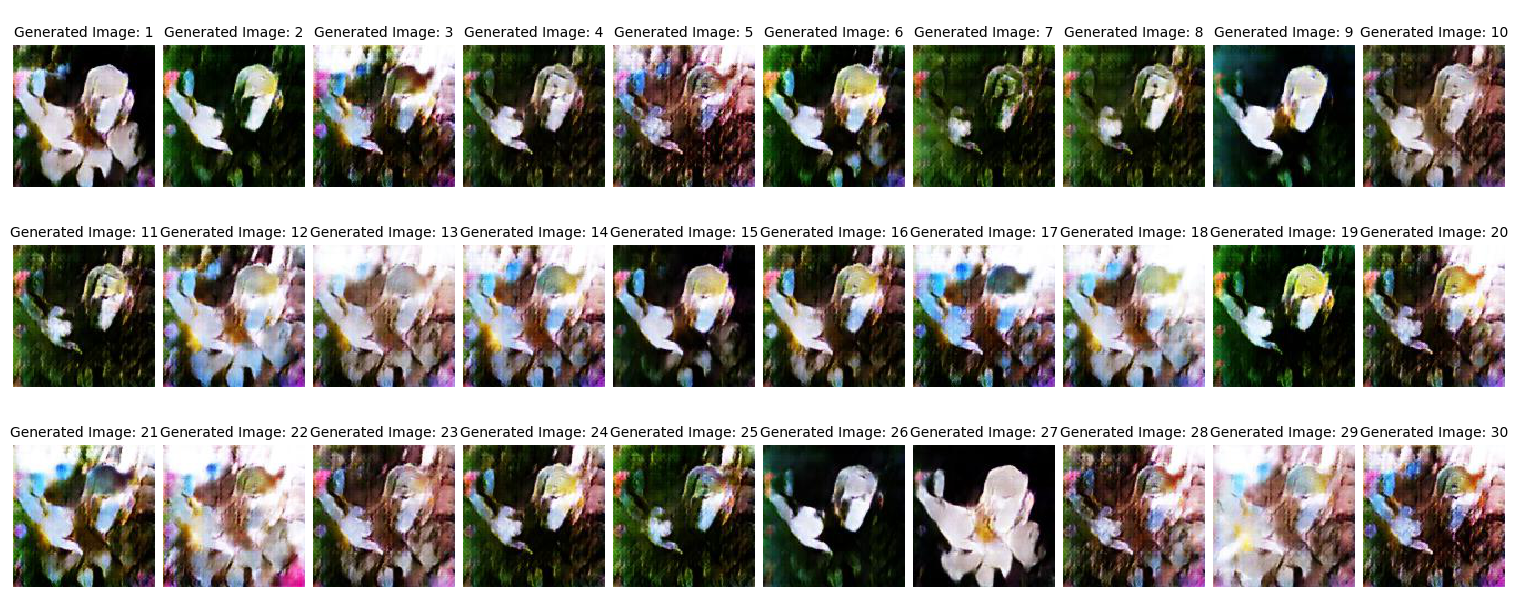

#### __Image Description 5:__ <u>_Black And White Flower_ 


In [8]:
with open('flowers_description.txt','r') as desc:
    l=desc.readlines()
    
desc_image_folder_path='Data/Flowers/images_generated_from_text/'
desc_folder_dir_list=os.listdir(desc_image_folder_path)
display(Markdown('# __<p style="text-align: center;">Images Generated From Text Description</p>__'))
for folders in range(len(desc_folder_dir_list)):
    images_dir_list=os.listdir(desc_image_folder_path+desc_folder_dir_list[folders])
    
    fig, axs = plt.subplots(3, 10, layout='constrained', figsize=(15, 6))
    fig.set_facecolor('1')
    img=list()
    for images in range(len(images_dir_list)):
        img=np.asarray(image.open(desc_image_folder_path+str(folders)+'/'+images_dir_list[images]))
        axs[images//10,images%10].imshow(img, interpolation='nearest')
        axs[images//10,images%10].axis('off')
        axs[images//10,images%10].set_title('\nGenerated Image: '+str(images+1),fontsize=10)
    
    plt.show()
    display(Markdown('#### __Image Description '+str(folders+1)+':__ <u>_'+l[folders].split('\n')[0].title()+'_ \n'))
    print('\n'*5)

# 

# ----------------------------------------------THE END--------------------------------------------------